In [1]:
# this clones the PGM repository in the ./PGM folder if it does not exists
# please modify this line as needed if you want to have the PMG repository elsewhere
import os, sys
pgm_path = './PGM/'
if not os.path.isdir(pgm_path): # check if folder exists
    from git import Repo
    Repo.clone_from("https://github.com/jertubiana/PGM.git", pgm_path)
sys.path.append('./PGM/source/')
sys.path.append('./PGM/utilities/')
sys.path.append('./DNA_utils/')

In [2]:
# imports
from common_imports import set_num_threads
set_num_threads(2) # Set the number of cores. Must be executed before importing numpy&numba.
import rbm, RBM_utils, utilities
import DNA_utils, DNA_sequence_logo, DNA_plots_utils

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
from scipy.optimize import curve_fit

%matplotlib inline

./PGM/source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T, V)
./PGM/source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  mean_V = np.dot(weights, V) / sum_weights


In [3]:
# load pre-trained RBM and pre-compute the partition functions
path = './trained_RBMs/'
file_name = 'RBM_DC6.data'
RBM_dc = RBM_utils.loadRBM(path + file_name)
RBM_dc.AIS(n_betas=40000,verbose=0)

(193.77951, 0.016669098422349184)

In [4]:
# load full datasets (must be in the ./data folder)
path = './data/'
filename = 's100_5th.fasta'
all_data_5, counts_5 = DNA_utils.load_DNA_MSA(path + filename, drop_duplicates=True, with_counts = True)

filename = 's100_6th.fasta'
all_data_6, counts_6 = DNA_utils.load_DNA_MSA(path + filename, drop_duplicates=True, with_counts = True)

filename = 's100_7th.fasta'
all_data_7, counts_7 = DNA_utils.load_DNA_MSA(path + filename, drop_duplicates=True, with_counts = True)

filename = 's100_8th.fasta'
all_data_8, counts_8 = DNA_utils.load_DNA_MSA(path + filename, drop_duplicates=True, with_counts = True)

In [5]:
# panel a
# compute likelihoods
liks_5_f = RBM_dc.likelihood(np.array(all_data_5))
liks_6_f = RBM_dc.likelihood(np.array(all_data_6))
liks_7_f = RBM_dc.likelihood(np.array(all_data_7))
liks_8_f = RBM_dc.likelihood(np.array(all_data_8))
avs = [np.average(liks_5_f, weights=counts_5), np.average(liks_6_f, weights=counts_6),
       np.average(liks_7_f, weights=counts_7), np.average(liks_8_f, weights=counts_8)]

In [6]:
# panel b
# compute number of bins
my_bins = []
nbins = 29
begin = min(liks_5_f)
end = max(liks_8_f)
bin_len = (end - begin) / nbins
p = begin
while p<=end:
    p += bin_len
    my_bins.append(p)

# compute histograms
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
h5_counts, h5_bins, h5_bars = axes[0, 0].hist(liks_5_f, weights=counts_5, bins=my_bins)
h5_x = [(h5_bins[i+1] + h5_bins[i])/2 for i in range(len(h5_bins)-1)]
h5_y = h5_counts.copy()
h6_counts, h6_bins, h6_bars = axes[0, 1].hist(liks_6_f, weights=counts_6, bins=my_bins)
h6_x = [(h6_bins[i+1] + h6_bins[i])/2 for i in range(len(h6_bins)-1)]
h6_y = h6_counts.copy()
h7_counts, h7_bins, h7_bars = axes[1, 0].hist(liks_7_f, weights=counts_7, bins=my_bins)
h7_x = [(h7_bins[i+1] + h7_bins[i])/2 for i in range(len(h7_bins)-1)]
h7_y = h7_counts.copy()
h8_counts, h8_bins, h8_bars = axes[1, 1].hist(liks_8_f, weights=counts_8, bins=my_bins)
h8_x = [(h8_bins[i+1] + h8_bins[i])/2 for i in range(len(h8_bins)-1)]
h8_y = h8_counts.copy()
plt.close() # do not show figure

# compute x and y points to be plotted in panel b
ratio_fit_5 = []
loglik_5 = []
for i in range(len(h5_y)):
    if h5_y[i] == 0 or h6_y[i]==0:
        print('zeros found in pos', i)
        continue
    loglik_5.append((my_bins[i+1]+my_bins[i])/2)
    ratio_fit_5.append(h6_y[i]/h5_y[i])
loglik_6=[]
ratio_fit_6 = []
for i in range(len(h6_y)):
    if h7_y[i] == 0 or h6_y[i]==0:
        print('zeros found in pos', i)
        continue
    loglik_6.append((my_bins[i+1]+my_bins[i])/2)
    ratio_fit_6.append(h7_y[i]/h6_y[i])
ratio_fit_7 = []
loglik_7=[]
for i in range(len(h6_y)):
    if h8_y[i] == 0 or h7_y[i]==0:
        print('zeros found in pos', i)
        continue
    loglik_7.append((my_bins[i+1]+my_bins[i])/2)
    ratio_fit_7.append(h8_y[i]/h7_y[i])
ratio_fit_5 = np.array(ratio_fit_5)
log_ratio_fit_5 = np.log(ratio_fit_5)
ratio_fit_6 = np.array(ratio_fit_6)
log_ratio_fit_6 = np.log(ratio_fit_6)
ratio_fit_7 = np.array(ratio_fit_7)
log_ratio_fit_7 = np.log(ratio_fit_7)
loglik_5 = np.array(loglik_5)
loglik_6 = np.array(loglik_6)
loglik_7 = np.array(loglik_7)

In [7]:
# fit to find center and variance of the peaks, and find seqs in peaks
my_bins = []
nbins = 29
begin = min(liks_5_f)
end = max(liks_8_f)
bin_len = (end - begin) / nbins
p = begin
while p<=end:
    p += bin_len
    my_bins.append(p)

h5_counts_dens, h5_bins_dens, h5_bars_dens = axes[0, 0].hist(liks_5_f, weights=counts_5, bins=my_bins, density=True)
h5_x = [(h5_bins_dens[i+1] + h5_bins_dens[i])/2 for i in range(len(h5_bins_dens)-1)]
h5_y = h5_counts_dens.copy()
def single_gauss(x, m1, x1, s1):
    return (m1 * np.exp(-(x-x1)**2/(2 * s1)) / np.sqrt(2 * np.pi * s1))
def multi_gauss(x, m1, m2, m3, x1, x2, x3, s1, s2, s3):
    return (m1 * np.exp(-(x-x1)**2/(2 * s1)) / np.sqrt(2 * np.pi * s1) + m2 * np.exp(-(x-x2)**2/(2 * s2)) / np.sqrt(2 * np.pi * s2) + m3 * np.exp(-(x-x3)**2/(2 * s3)) / np.sqrt(2 * np.pi * s3))
popt5, pcov5 = curve_fit(multi_gauss, h5_x, h5_y, 
                         p0 = [0.1, 0.1, 0.1, -57, -42, -28, 10, 10, 10], 
                         bounds=([0,0,0,-65,-50,-35,0.01,0.01,0.01], [1,1,1,-55,-35,-20,100,100,100]))
t_pars1 = popt5[[0,3,6]]
t_pars2 = popt5[[1,4,7]]
t_pars3 = popt5[[2,5,8]]
peak1 = (t_pars1[1] - np.sqrt(t_pars1[2]), t_pars1[1] + np.sqrt(t_pars1[2]))
peak2 = (t_pars2[1] - np.sqrt(t_pars2[2]), t_pars2[1] + np.sqrt(t_pars2[2]))
peak3 = (t_pars3[1] - np.sqrt(t_pars3[2]), t_pars3[1] + np.sqrt(t_pars3[2]))
seq_peak1 = []
seq_peak2 = []
seq_peak3 = []
for i, ll in enumerate(liks_5_f):
    #print(ll)
    if ll > peak1[0] and ll < peak1[1]:
        seq_peak1.append(list(all_data_5[i]))
    if ll > peak2[0] and ll < peak2[1]: 
        seq_peak2.append(list(all_data_5[i]))
    if ll > peak3[0] and ll < peak3[1]:
        seq_peak3.append(list(all_data_5[i]))
    #print(len(seq_peak1), len(seq_peak2), len(seq_peak3))
seq_peak1 = np.array(seq_peak1)
seq_peak2 = np.array(seq_peak2)
seq_peak3 = np.array(seq_peak3)

(inset) linear fit slope: 0.8191288204528391 linear fit intercept: 0.0052860750804612005


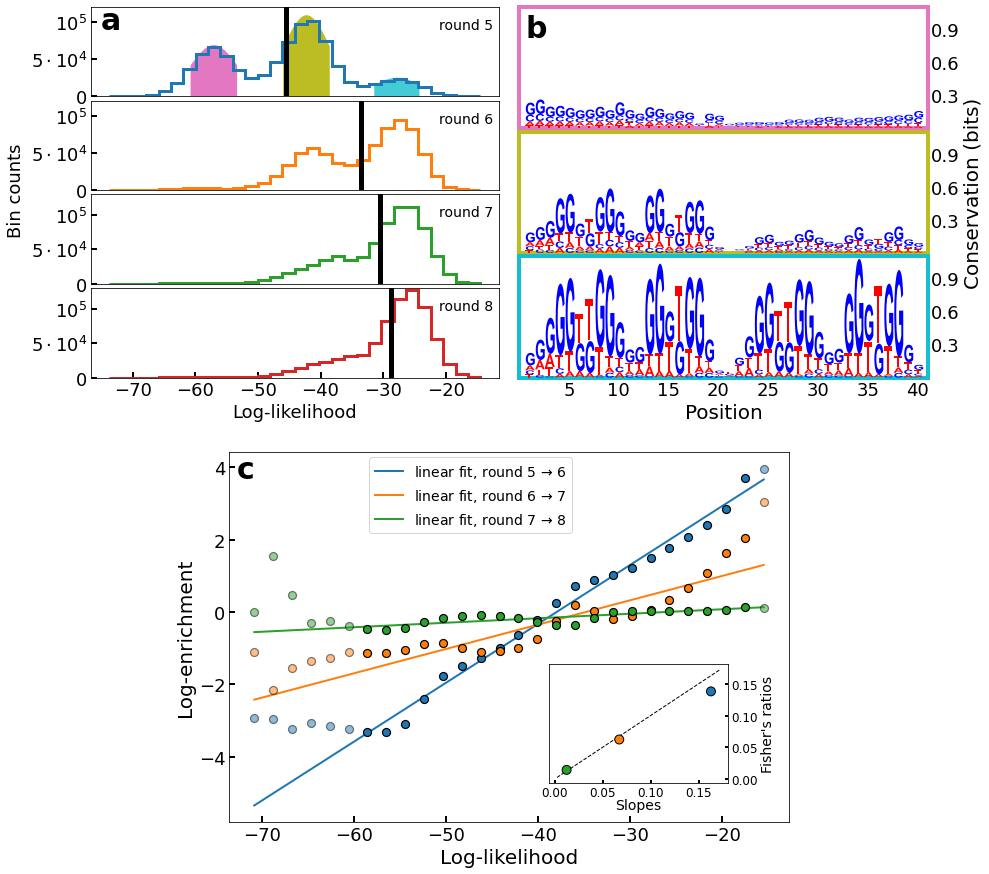

In [8]:
fig = plt.figure(figsize=(15, 15), constrained_layout=False)
gs = fig.add_gridspec(ncols=1, nrows=2, wspace=0.1, hspace=0.2) # I could also choose here some width_ratios or height_ratios

wr1 = [1, 1]
gs1 = gs[0,0].subgridspec(ncols=2, nrows=1, wspace=0.05, hspace=0.1, width_ratios=wr1)
wr2 = [0.2, 1, 0.2]
gs2 = gs[1,0].subgridspec(ncols=3, nrows=1, wspace=0.1, hspace=0.1, width_ratios=wr2)
#################################################################################################################
# histograms
hr1 = [1, 1, 1, 1]
gs11 = gs1[0,0].subgridspec(ncols=1, nrows=4, height_ratios=hr1, hspace=0.05)

fact = h5_counts[0] / h5_counts_dens[0]
t_pars1 = popt5[[0,3,6]]
t_pars2 = popt5[[1,4,7]]
t_pars3 = popt5[[2,5,8]]
ax11 = fig.add_subplot(gs11[0,0])
ax11.hist(liks_5_f, weights=counts_5, bins=30, alpha=1, histtype='step', lw=3, fill=False, color="C0")
ax11.axvline(x=avs[0], linewidth=5, color='black', label='Average')
x_fill = np.arange(t_pars1[1] - np.sqrt(t_pars1[2]), t_pars1[1] + np.sqrt(t_pars1[2]), 0.1)
ax11.fill_between(x_fill, single_gauss(x_fill, *t_pars1) * fact, facecolor='tab:pink', alpha=1)
x_fill = np.arange(t_pars2[1] - np.sqrt(t_pars2[2]), t_pars2[1] + np.sqrt(t_pars2[2]), 0.1)
ax11.fill_between(x_fill, single_gauss(x_fill, *t_pars2) * fact, facecolor='tab:olive', alpha=1)
x_fill = np.arange(t_pars3[1] - np.sqrt(t_pars3[2]), t_pars3[1] + np.sqrt(t_pars3[2]), 0.1)
ax11.fill_between(x_fill, single_gauss(x_fill, *t_pars3) * fact, facecolor='tab:cyan', alpha=0.8)
ax11.set_yticks([0, 5e4, 10e4])
ax11.set_yticklabels([r"0", r"$5 \cdot 10^4$", r"$10^5$"])
ax11.set_xticks([])
ax11.set_ylim((0, 120000))
#ax11.minorticks_on()
ax11.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax11.tick_params(axis='y', which='minor', direction='in', length=3, width=1, colors='k')
ax11.tick_params(axis='both', labelsize=18)
ax11.text(0.92, 0.8, 'round 5', horizontalalignment='center', verticalalignment='center', transform=ax11.transAxes,
             fontsize=14)


ax12 = fig.add_subplot(gs11[1,0])
ax12.hist(liks_6_f, weights=counts_6, bins=30, histtype='step', lw=3, fill=False, color="C1")
ax12.axvline(x=avs[1], linewidth=5, color='black', label='Average')
ax12.set_yticks([0, 5e4, 10e4])
ax12.set_yticklabels([r"0", r"$5 \cdot 10^4$", r"$10^5$"])
ax12.set_xticks([])
ax12.set_ylabel('Bin counts', fontsize=18)
ax12.yaxis.set_label_coords(-0.16,0)
ax12.set_ylim((0, 120000))
#ax12.minorticks_on()
ax12.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax12.tick_params(axis='y', which='minor', direction='in', length=3, width=1, colors='k')
ax12.tick_params(axis='both', labelsize=18)
ax12.text(0.92, 0.8, 'round 6', horizontalalignment='center', verticalalignment='center', transform=ax12.transAxes,
             fontsize=14)

ax13 = fig.add_subplot(gs11[2,0])
ax13.hist(liks_7_f, weights=counts_7, bins=30, histtype='step', lw=3, fill=False, color="C2")
ax13.axvline(x=avs[2], linewidth=5, color='black', label='Average')
ax13.set_yticks([0, 5e4, 10e4])
ax13.set_yticklabels([r"0", r"$5 \cdot 10^4$", r"$10^5$"])
ax13.set_xticks([])
ax13.set_ylim((0, 130000))
#ax13.minorticks_on()
ax13.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax13.tick_params(axis='y', which='minor', direction='in', length=3, width=1, colors='k')
ax13.tick_params(axis='both', labelsize=18)
ax13.text(0.92, 0.8, 'round 7', horizontalalignment='center', verticalalignment='center', transform=ax13.transAxes,
             fontsize=14)

ax14 = fig.add_subplot(gs11[3,0])
ax14.hist(liks_8_f, weights=counts_8, bins=30, histtype='step', lw=3, fill=False, color="C3")
ax14.axvline(x=avs[3], linewidth=5, color='black', label='Average')
ax14.set_xlabel('Log-likelihood', fontsize=18)
ax14.set_ylim((0, 130000))
ax14.set_yticks([0, 5e4, 10e4])
ax14.set_yticklabels([r"0", r"$5 \cdot 10^4$", r"$10^5$"])
#ax14.minorticks_on()
ax14.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax14.tick_params(axis='y', which='minor', direction='in', length=3, width=1, colors='k')
ax14.tick_params(axis='x', which='minor', direction='in', length=0, width=1, colors='k')
ax14.tick_params(axis='both', labelsize=18)
ax14.text(0.92, 0.8, 'round 8', horizontalalignment='center', verticalalignment='center', transform=ax14.transAxes,
             fontsize=14)

ax11.text(0.025, 0.75, 'a', fontsize=30, color='k', weight='bold', transform=ax11.transAxes)
#################################################################################################################
gs12 = gs1[0,1].subgridspec(ncols=1, nrows=3, hspace=0.03)

ax21 = fig.add_subplot(gs12[0,0])
rect1 = patches.Rectangle((0.0, 0.0), 1, 1, linewidth=4, edgecolor='tab:pink',
                          facecolor='none', transform=ax21.transAxes, clip_on=False)
ax21.add_patch(rect1)
mu = utilities.average(seq_peak1,c=4)
DNA_sequence_logo.Sequence_logo(mu, ticks_every=5, ax=ax21, show=False, figsize=(5,5))
ax21.set_xticks([])
ax21.set_ylim((0,1.1))
ax21.set_yticks([0.3, 0.6, 0.9])
ax21.tick_params(axis='both', direction='in', length=0, width=2, colors='k')
ax21.tick_params(axis='both', labelsize=18)
ax21.yaxis.tick_right()
ax21.set_ylabel("")
[ax21.spines[x].set_linewidth(0.) for x in ax21.spines.keys()]

ax22 = fig.add_subplot(gs12[1,0])
rect2 = patches.Rectangle((0.0, 0.0), 1, 1, linewidth=4, edgecolor='tab:olive',
                          facecolor='none', transform=ax22.transAxes, clip_on=False)
ax22.add_patch(rect2)
mu = utilities.average(seq_peak2,c=4)
DNA_sequence_logo.Sequence_logo(mu, ticks_every=5, ax=ax22, show=False, figsize=(5,5))
ax22.set_xticks([])
ax22.set_ylim((0,1.1))
ax22.set_yticks([0.3, 0.6, 0.9])
ax22.tick_params(axis='both', direction='in', length=0, width=2, colors='k')
ax22.tick_params(axis='both', labelsize=18)
ax22.yaxis.tick_right()
ax22.yaxis.set_label_position("right")
[ax22.spines[x].set_linewidth(0.) for x in ax21.spines.keys()]

ax23 = fig.add_subplot(gs12[2,0])
rect3 = patches.Rectangle((0.0, 0.0), 1, 1, linewidth=4, edgecolor='tab:cyan',
                          facecolor='none', transform=ax23.transAxes, clip_on=False)
ax23.add_patch(rect3)
mu = utilities.average(seq_peak3,c=4)
DNA_sequence_logo.Sequence_logo(mu, ticks_every=5, ax=ax23, show=False, figsize=(5,5))
ax23.set_ylim((0,1.1))
ax23.set_yticks([0.3, 0.6, 0.9])
ax23.tick_params(axis='both', direction='in', length=0, width=2, colors='k')
ax23.tick_params(axis='both', labelsize=18)
ax23.yaxis.tick_right()
ax23.set_ylabel("")
ax23.set_xlabel('Position', fontsize=20)
[ax23.spines[x].set_linewidth(0.) for x in ax21.spines.keys()]


ax21.text(0.015, 0.75, 'b', fontsize=30, color='k', weight='bold', transform=ax21.transAxes)
#################################################################################################################
ax3 = fig.add_subplot(gs2[0,1])
# fit (non weighted - see above, errors do not change much)
# moreover, fit only points with lim_m < loglikelihood < lim_p
lim_m = -60
lim_p = -17
ll5 = np.array(loglik_5)[(np.array(loglik_5)>lim_m) & (np.array(loglik_5)<lim_p)]
lr5 = np.array(log_ratio_fit_5)[(np.array(loglik_5)>lim_m) & (np.array(loglik_5)<lim_p)]
ll6 = np.array(loglik_6)[(np.array(loglik_6)>lim_m) & (np.array(loglik_6)<lim_p)]
lr6 = np.array(log_ratio_fit_6)[(np.array(loglik_6)>lim_m) & (np.array(loglik_6)<lim_p)]
ll7 = np.array(loglik_7)[(np.array(loglik_7)>lim_m) & (np.array(loglik_7)<lim_p)]
lr7 = np.array(log_ratio_fit_7)[(np.array(loglik_7)>lim_m) & (np.array(loglik_7)<lim_p)]

coef5 = np.polyfit(ll5, lr5, 1)
poly1d_fn5 = np.poly1d(coef5)
coef6 = np.polyfit(ll6, lr6, 1)
poly1d_fn6 = np.poly1d(coef6)
coef7 = np.polyfit(ll7, lr7, 1)
poly1d_fn7 = np.poly1d(coef7)

# plot points
ax3.plot(loglik_5[loglik_5<lim_m], log_ratio_fit_5[loglik_5<lim_m], 'o', markersize=8, markerfacecolor="C0", markeredgewidth=1.2,
         markeredgecolor="black", zorder=2, alpha=0.5)
ax3.plot(loglik_5[loglik_5>lim_p], log_ratio_fit_5[loglik_5>lim_p], 'o', markersize=8, markerfacecolor="C0", markeredgewidth=1.2,
         markeredgecolor="black", zorder=2, alpha=0.5)
ax3.plot(ll5, lr5, 'o', markersize=8, markerfacecolor="C0", markeredgewidth=1.2,
         markeredgecolor="black", zorder=2, alpha=1)
ax3.plot(loglik_6[loglik_6<lim_m], log_ratio_fit_6[loglik_6<lim_m], 'o', markersize=8, markerfacecolor="C1", markeredgewidth=1.2,
         markeredgecolor="black", zorder=2, alpha=0.5)
ax3.plot(loglik_6[loglik_6>lim_p], log_ratio_fit_6[loglik_6>lim_p], 'o', markersize=8, markerfacecolor="C1", markeredgewidth=1.2,
         markeredgecolor="black", zorder=2, alpha=0.5)
ax3.plot(ll6, lr6, 'o', markersize=8, markerfacecolor="C1", markeredgewidth=1.2,
         markeredgecolor="black", zorder=2, alpha=1)
ax3.plot(loglik_7[loglik_7<lim_m], log_ratio_fit_7[loglik_7<lim_m], 'o', markersize=8, markerfacecolor="C2", markeredgewidth=1.2,
         markeredgecolor="black", zorder=2, alpha=0.5)
ax3.plot(loglik_7[loglik_7>lim_p], log_ratio_fit_7[loglik_7>lim_p], 'o', markersize=8, markerfacecolor="C2", markeredgewidth=1.2,
         markeredgecolor="black", zorder=2, alpha=0.5)
ax3.plot(ll7, lr7, 'o', markersize=8, markerfacecolor="C2", markeredgewidth=1.2,
         markeredgecolor="black", zorder=2, alpha=1)

# plot fits
xx = np.arange(min(loglik_5), max(loglik_7), 0.05)
ax3.plot(xx, poly1d_fn5(xx), color='C0', label=r'linear fit, round 5 $\to$ 6', lw=2, zorder=-1)
ax3.plot(xx, poly1d_fn6(xx), color='C1', label=r'linear fit, round 6 $\to$ 7', lw=2, zorder=-1)
ax3.plot(xx, poly1d_fn7(xx), color='C2', label=r'linear fit, round 7 $\to$ 8', lw=2, zorder=-1)
ax3.legend(fontsize=14, loc=(0.25,0.78))

####################
# inset
inset_type = "alphainference" # linearfit or alphainference

avs = [np.average(liks_5_f, weights=counts_5), np.average(liks_6_f, weights=counts_6),
       np.average(liks_7_f, weights=counts_7), np.average(liks_8_f, weights=counts_8)]
var = [np.average(liks_5_f**2, weights=counts_5) - np.average(liks_5_f, weights=counts_5)**2, 
       np.average(liks_6_f**2, weights=counts_6) - np.average(liks_6_f, weights=counts_6)**2, 
       np.average(liks_7_f**2, weights=counts_7) - np.average(liks_7_f, weights=counts_7)**2, 
       np.average(liks_8_f**2, weights=counts_8) - np.average(liks_8_f, weights=counts_8)**2]
x = [avs[i]-avs[i-1] for i in range(1, len(avs))]
y = [var[i] for i in range(len(var)-1)]


if inset_type == "linearfit":
    coef = np.polyfit(x, y, 1)
    poly1d_fn = np.poly1d(coef) 
    xx = np.arange(min(x)-1, max(x)+1, 0.05)
    axins = inset_axes(ax3, width="100%", height="100%",
                       bbox_to_anchor=(.58, .12, .32, .32),
                       bbox_transform=ax3.transAxes)
    axins.scatter(x, y, s=80, edgecolors='k', color=["C0","C1","C2"])
    axins.plot(xx, poly1d_fn(xx), color='black', label='linear fit', lw=1, linestyle="dashed", zorder=-5)
    axins.tick_params(axis='both', direction='in', length=3, width=2, colors='k')
    axins.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
    axins.tick_params(axis='both', labelsize=12)
    axins.set_xlabel(r'$\Delta\langle\mathcal{L}\rangle$', fontsize=14)
    axins.set_ylabel(r'$\mathcal{L}$ variance', fontsize=14)
    axins.yaxis.tick_right()
    axins.yaxis.set_label_position("right")
    axins.yaxis.set_label_coords(1.12, 0.5)
    axins.xaxis.set_label_coords(0.5, -0.12)

elif inset_type == "alphainference":
    xx = [coef5[0], coef6[0], coef7[0]]
    yy = [x[i] / y[i] for i in range(3)]
    
    coef = np.polyfit(xx, yy, 1)
    poly1d_fn = np.poly1d(coef) 
    xxx = np.arange(min(xx)-0.01, max(xx)+0.01, 0.01)
    
    axins = inset_axes(ax3, width="100%", height="100%",
                       bbox_to_anchor=(.58, .12, .32, .32),
                       bbox_transform=ax3.transAxes)
    axins.scatter(xx, yy, s=80, edgecolors='k', color=["C0","C1","C2"])
#    axins.plot(xxx, poly1d_fn(xxx), color='white', label='linear fit', lw=2, zorder=-5)
    axins.plot(xxx, xxx, color='black', label='x=y', lw=1, linestyle="dashed", zorder=-5)
    axins.tick_params(axis='both', direction='in', length=3, width=2, colors='k')
    axins.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
    axins.tick_params(axis='both', labelsize=12)
    axins.set_xlabel('Slopes', fontsize=14)
    axins.set_ylabel("Fisher's ratios", fontsize=14)
    axins.yaxis.tick_right()
    axins.yaxis.set_label_position("right")
    axins.yaxis.set_label_coords(1.18, 0.5)
    axins.xaxis.set_label_coords(0.5, -0.13)
    print("(inset) linear fit slope:", coef[0], "linear fit intercept:", coef[1])

    
    
####################

#ax3.yaxis.tick_right()
#ax3.yaxis.set_label_position("right")
ax3.set_xlabel('Log-likelihood', fontsize=20)
ax3.set_ylabel('Log-enrichment', fontsize=20)
ax3.tick_params(axis='both', labelsize=18)
ax3.text(0.015, 0.93, 'c', fontsize=30, color='k', weight='bold', transform=ax3.transAxes)
ax3.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax3.tick_params(axis='both', labelsize=18)
#################################################################################################################